<a href="https://colab.research.google.com/github/sushirito/ArsenicFR/blob/main/WavelengthStatistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


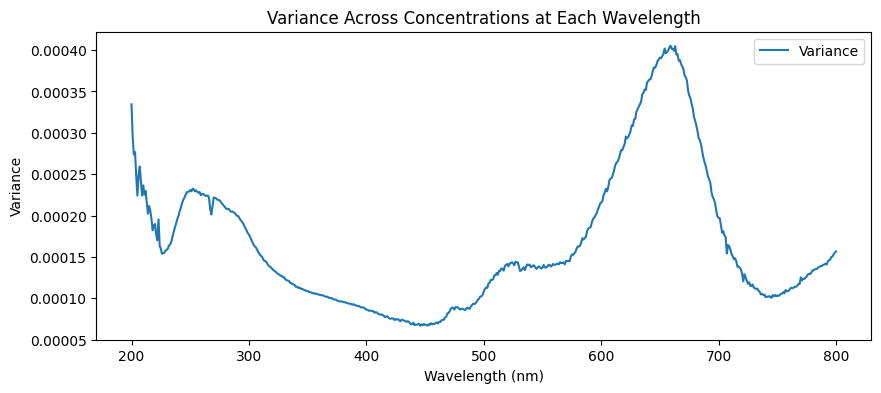

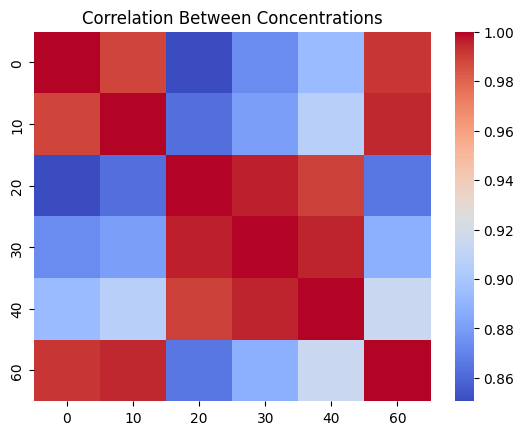

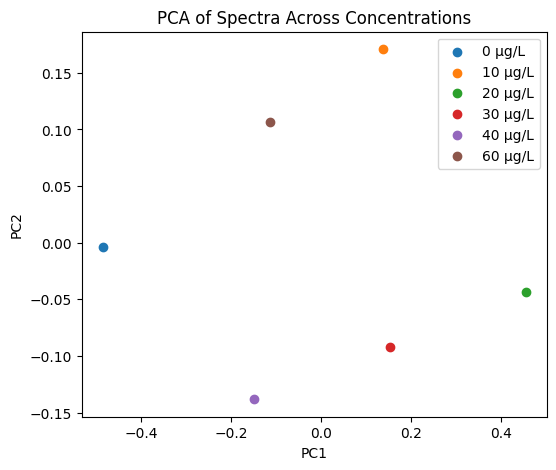

  Concentration  Peak_Wavelength  Peak_Absorbance
0             0              200          0.26086
1            10              200          0.27355
2            20              200          0.27486
3            30              200          0.26196
4            40              200          0.22852
5            60              200          0.28692


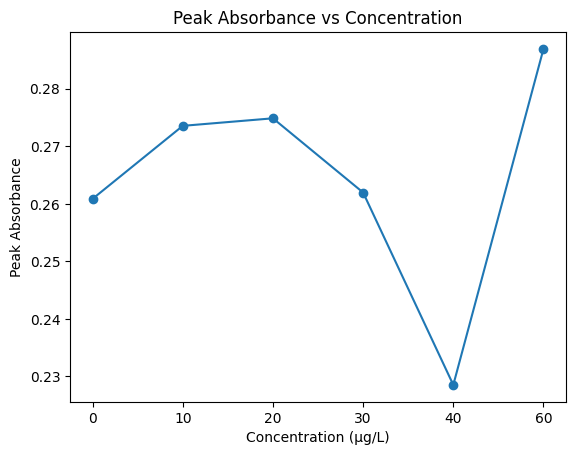

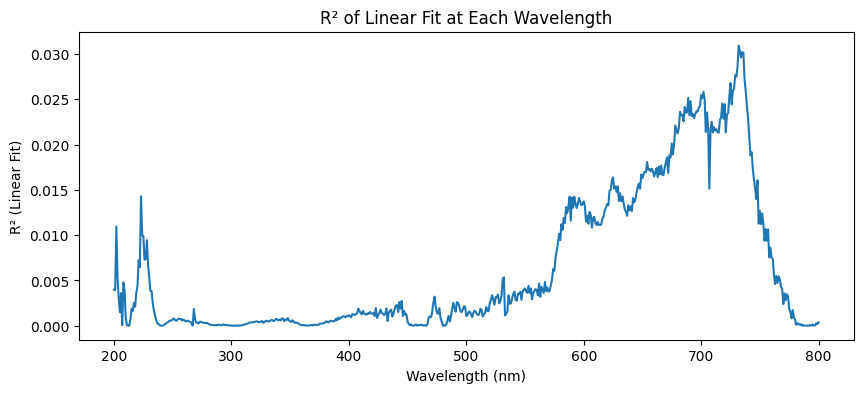

  Concentration  Skewness   Kurtosis
0             0  3.842041  19.726574
1            10  2.970529  12.891424
2            20  1.833262   5.697987
3            30  2.314574   9.547565
4            40  2.337827   9.547731
5            60  3.407089  16.846965
    Pair  Euclidean_Distance
0   0→10            0.651778
1  10→20            0.389499
2  20→30            0.308854
3  30→40            0.310454
4  40→60            0.256839


In [1]:
# ===== 1. Setup and Data Load =====
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import skew, kurtosis

file_path = '/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv'
df = pd.read_csv(file_path)

# Ensure column names are strings
df.columns = df.columns.astype(str)

# Extract wavelength and concentration arrays
wavelengths = df['Wavelength'].values
concs = [col for col in df.columns if col != 'Wavelength']
spectra = df[concs].values.T  # shape: (num_concs, num_wavelengths)

# ===== 2. Per-Wavelength Summary Statistics =====
stats_df = pd.DataFrame({
    'Wavelength': wavelengths,
    'Mean': np.mean(spectra, axis=0),
    'Variance': np.var(spectra, axis=0),
    'Min': np.min(spectra, axis=0),
    'Max': np.max(spectra, axis=0),
    'CoeffVar': np.std(spectra, axis=0) / np.mean(spectra, axis=0)
})

plt.figure(figsize=(10,4))
plt.plot(wavelengths, stats_df['Variance'], label='Variance')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Variance')
plt.title('Variance Across Concentrations at Each Wavelength')
plt.legend()
plt.show()

# ===== 3. Correlation Heatmap Between Wavelengths =====
corr_matrix = np.corrcoef(spectra)
sns.heatmap(corr_matrix, cmap='coolwarm', xticklabels=concs, yticklabels=concs)
plt.title('Correlation Between Concentrations')
plt.show()

# ===== 4. PCA Analysis =====
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(spectra)
plt.figure(figsize=(6,5))
for i, c in enumerate(concs):
    plt.scatter(pca_scores[i,0], pca_scores[i,1], label=f"{c} µg/L")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Spectra Across Concentrations')
plt.legend()
plt.show()

# ===== 5. Peak & Shape Features =====
def peak_features(spectrum, wl):
    peak_idx = np.argmax(spectrum)
    peak_wl = wl[peak_idx]
    peak_val = spectrum[peak_idx]
    return peak_wl, peak_val

peak_data = []
for i, c in enumerate(concs):
    peak_wl, peak_val = peak_features(spectra[i], wavelengths)
    peak_data.append((c, peak_wl, peak_val))
peak_df = pd.DataFrame(peak_data, columns=['Concentration', 'Peak_Wavelength', 'Peak_Absorbance'])
print(peak_df)

plt.figure()
plt.plot(peak_df['Concentration'], peak_df['Peak_Absorbance'], marker='o')
plt.xlabel('Concentration (µg/L)')
plt.ylabel('Peak Absorbance')
plt.title('Peak Absorbance vs Concentration')
plt.show()

# ===== 6. Wavelength-wise Regression Trends =====
r2_linear = []
for idx, wl in enumerate(wavelengths):
    y = spectra[:, idx]
    x = np.array(concs, dtype=float).reshape(-1,1)
    model = LinearRegression().fit(x, y)
    r2_linear.append(r2_score(y, model.predict(x)))

plt.figure(figsize=(10,4))
plt.plot(wavelengths, r2_linear)
plt.xlabel('Wavelength (nm)')
plt.ylabel('R² (Linear Fit)')
plt.title('R² of Linear Fit at Each Wavelength')
plt.show()

# ===== 7. Distribution Shape Analysis =====
dist_stats = []
for i, c in enumerate(concs):
    skewness = skew(spectra[i])
    kurt = kurtosis(spectra[i])
    dist_stats.append((c, skewness, kurt))
dist_df = pd.DataFrame(dist_stats, columns=['Concentration', 'Skewness', 'Kurtosis'])
print(dist_df)

# ===== 8. Spectral Distance Between Concentrations =====
from scipy.spatial.distance import euclidean
distances = []
for i in range(len(concs)-1):
    d = euclidean(spectra[i], spectra[i+1])
    distances.append((f"{concs[i]}→{concs[i+1]}", d))
dist_df2 = pd.DataFrame(distances, columns=['Pair', 'Euclidean_Distance'])
print(dist_df2)
